# 그림일기 텍스트 탐지·인식 파이프라인 (VARCO-VISION-2.0-1.7B-OCR)

아동 심리 분석용 그림일기 이미지에서 **텍스트 영역을 탐지**하고 **OCR**로 인식하는 파이프라인입니다.

- **전처리**: 제공된 문서 보정·정리 코드 포함 (4점 변환, adaptive cleanup)
- **모델**: NCSOFT VARCO-VISION-2.0-1.7B-OCR
- **VRAM**: 6GB 대응을 위한 4-bit 양자화(bitsandbytes) 적용

## 1. 환경 확인 (CUDA / VRAM)

**GPU 사용 가능: False인 경우**  
1. **커널 확인**: 우측 상단 커널이 프로젝트 **venv**인지 확인하세요. (다른 Python이면 GPU용 torch가 없을 수 있음)  
2. **터미널**에서 (Jupyter/Cursor 모두 끈 뒤):
   ```bash
   cd c:\ddddwoo\project\Oneness\AiMind-AiModels
   .\venv\Scripts\activate
   pip uninstall torch torchvision -y
   pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118
   ```
3. Cursor/Jupyter 다시 켜고, **커널을 이 프로젝트 venv로 선택**한 뒤 **커널 재시작** → "환경 확인" 셀 다시 실행.

In [ ]:
import sys
import torch

# 현재 커널이 쓰는 Python (venv인지 확인)
print(f"Python: {sys.executable}")
print(f"torch 위치: {torch.__file__}")
print(f"torch CUDA 버전: {torch.version.cuda}")  # None이면 CPU 전용 빌드
print()

cuda_available = torch.cuda.is_available()
print(f"GPU 사용 가능: {cuda_available}")

if cuda_available:
    current_device = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(current_device)
    total_mem = torch.cuda.get_device_properties(current_device).total_memory / 1e9
    print(f"장치: {device_name}")
    print(f"VRAM: {total_mem:.2f} GB")
else:
    print("⚠️ CUDA를 사용할 수 없습니다. CPU로 실행 시 메모리·속도에 제한이 있을 수 있습니다.")
    if torch.version.cuda is None:
        print("   → torch.version.cuda가 None: CPU 전용 PyTorch가 설치된 상태입니다. 아래 'GPU 사용 불가 시' 안내를 따르세요.")

Python: c:\ddddwoo\project\Oneness\AiMind-AiModels\venv\Scripts\python.exe
torch 위치: c:\ddddwoo\project\Oneness\AiMind-AiModels\venv\Lib\site-packages\torch\__init__.py
torch CUDA 버전: 11.8

GPU 사용 가능: True
장치: NVIDIA GeForce RTX 3060 Laptop GPU
VRAM: 6.44 GB


## 2. 의존성 설치 (최초 1회)

**CUDA 11.8 + 한국어 OCR(VARCO) 호환 버전.** 아래 순서대로 실행하세요.

In [ ]:
# [1] PyTorch (CUDA 11.8 전용) - 먼저 실행
# %pip uninstall torch torchvision -y
# %pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118

# [2] 나머지 패키지 (transformers 4.53.x만 - 4.54+는 torch._export 호환 문제)
%pip install "transformers>=4.53.1,<4.54" "opencv-python>=4.8.0" "matplotlib>=3.7" "Pillow>=10.0" "numpy>=1.24" "bitsandbytes>=0.43.0" "accelerate>=0.30.0"

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# "No module named 'matplotlib'" 등 나오면 이 셀만 실행한 뒤, 아래 "임포트" 셀 다시 실행
%pip install matplotlib opencv-python numpy Pillow --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 3. 임포트 및 메모리 설정

In [ ]:
# CUDA 11.8 + 한국어 OCR 호환 (torch는 cu118, transformers 4.53+, opencv-python, bitsandbytes 0.43+)
import os
import gc
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration, BitsAndBytesConfig

# VRAM 파편화 완화 (6GB 환경 권장)
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

def clean_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

clean_memory()
print("임포트 및 메모리 설정 완료.")

임포트 및 메모리 설정 완료.


## 4. 이미지 전처리 (제공 코드 포함)

그림일기 이미지에서 문서 영역을 찾아 보정하고, 텍스트 가독성을 위한 정리(adaptive cleanup)를 적용합니다.

In [ ]:
def imshow(title, image):
    plt.figure(figsize=(12, 12))
    plt.title(title)
    if len(image.shape) == 3:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    dst = np.array([[0, 0], [maxWidth - 1, 0], [maxWidth - 1, maxHeight - 1], [0, maxHeight - 1]], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    return cv2.warpPerspective(image, M, (maxWidth, maxHeight))

def expand_contour(cnt, scale=1.03):
    M = cv2.moments(cnt)
    if M['m00'] == 0:
        return cnt
    cx = int(M['m10'] / M['m00'])
    cy = int(M['m01'] / M['m00'])
    cnt_norm = cnt - [cx, cy]
    cnt_scaled = cnt_norm * scale
    cnt_new = cnt_scaled + [cx, cy]
    return cnt_new.astype(np.int32)

def adaptive_cleanup(image):
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 40))
    bg_estimation = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)
    normalized = cv2.divide(gray, bg_estimation, scale=255)
    smoothed = cv2.bilateralFilter(normalized, d=9, sigmaColor=75, sigmaSpace=75)
    otsu_thresh, _ = cv2.threshold(smoothed, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    cutoff = min(otsu_thresh + 15, 255)
    _, clean_result = cv2.threshold(smoothed, cutoff, 255, cv2.THRESH_TRUNC)
    final_output = cv2.normalize(clean_result, None, 0, 255, cv2.NORM_MINMAX)
    return final_output

print("전처리 함수 정의 완료.")

전처리 함수 정의 완료.


In [ ]:
def preprocess_diary_image(file_path, show_result=False, use_color_for_ocr=True, return_detection_vis=False):
    """문서 영역 보정 + cleanup. return_detection_vis=True면 원본에 탐지된 문서 영역(4각형) 그린 이미지도 반환."""
    image = cv2.imread(file_path)
    if image is None:
        raise FileNotFoundError(f"이미지를 찾을 수 없습니다: {file_path}")

    orig = image.copy()
    ratio = image.shape[0] / 500.0
    h, w = 500, int(image.shape[1] / ratio)
    image_resized = cv2.resize(image, (w, h))

    gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(gray, 50, 150)
    kernel_edge = np.ones((5, 5), np.uint8)
    edged = cv2.dilate(edged, kernel_edge, iterations=1)

    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]

    screenCnt = None
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            screenCnt = approx
            break

    if screenCnt is None and len(cnts) > 0:
        rect = cv2.minAreaRect(cnts[0])
        box = cv2.boxPoints(rect)
        screenCnt = np.int0(box)

    detection_vis_bgr = None
    if screenCnt is None:
        warped = orig
        if return_detection_vis:
            detection_vis_bgr = orig.copy()
            cv2.putText(detection_vis_bgr, "Document not detected", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 2)
    else:
        screenCnt = expand_contour(screenCnt, scale=1.03)
        pts_orig = (screenCnt.reshape(4, 2) * ratio).astype(np.int32)
        warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)
        if return_detection_vis:
            detection_vis_bgr = orig.copy()
            cv2.polylines(detection_vis_bgr, [pts_orig], True, (0, 255, 0), 3)
            for i, pt in enumerate(pts_orig):
                cv2.circle(detection_vis_bgr, tuple(pt), 8, (0, 0, 255), -1)
                cv2.putText(detection_vis_bgr, str(i+1), tuple(pt), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2)

    final_result = adaptive_cleanup(warped)
    final_bgr = cv2.cvtColor(final_result, cv2.COLOR_GRAY2BGR)
    # OCR용: 손글씨는 컬러가 나을 수 있음 (use_color_for_ocr=True)
    if use_color_for_ocr:
        pil_image = Image.fromarray(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    else:
        pil_image = Image.fromarray(cv2.cvtColor(final_result, cv2.COLOR_GRAY2RGB))

    if show_result:
        imshow("Smart Clean Scan Result", final_result)

    return pil_image, final_bgr

## 5. VARCO-VISION-2.0-1.7B-OCR 모델 로드 (4-bit 양자화)

6GB VRAM에 맞추어 `bitsandbytes` 4-bit 양자화로 로드합니다.

In [ ]:
if "model" in globals():
    del model
clean_memory()

model_id = "NCSOFT/VARCO-VISION-2.0-1.7B-OCR"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
)

print("모델 로딩 중 (4-bit, VRAM 절약)...")
model = LlavaOnevisionForConditionalGeneration.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",
    attn_implementation="sdpa",
    low_cpu_mem_usage=True,
)
processor = AutoProcessor.from_pretrained(model_id)
print("모델 로드 완료.")

모델 로딩 중 (4-bit, VRAM 절약)...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


모델 로드 완료.


## 6. OCR 실행 및 결과 파싱

모델 출력 형식: `<char>문자</char><bbox>x1, y1, x2, y2</bbox>` → 텍스트와 바운딩 박스 추출

In [ ]:
def parse_ocr_output(output_text):
    """
    VARCO OCR 출력에서 <char>...</char> 와 <bbox>...</bbox> 쌍을 추출.
    반환: list of dict [{"text": str, "bbox": [x1, y1, x2, y2]}, ...], 전체 텍스트(연결)
    """
    text_boxes = []
    full_text_parts = []
    # <char>...</char><bbox>...</bbox> 패턴 (공백/줄바꿈 허용)
    pattern = re.compile(r"<char>\s*([^<]*?)\s*</char>\s*<bbox>\s*([^<]*?)\s*</bbox>", re.DOTALL)
    for m in pattern.finditer(output_text):
        text = m.group(1).strip()
        bbox_str = m.group(2).strip()
        full_text_parts.append(text)
        try:
            coords = [float(x.strip()) for x in bbox_str.split(",")]
            if len(coords) >= 4:
                text_boxes.append({"text": text, "bbox": coords[:4]})
        except (ValueError, AttributeError):
            text_boxes.append({"text": text, "bbox": None})
    full_text = "".join(full_text_parts) if full_text_parts else output_text
    return text_boxes, full_text


def get_diary_text(raw_output, full_text):
    """파싱된 full_text가 반복 문자 등 이상하면 raw에서 태그 제거한 텍스트를, 없으면 raw 그대로 반환."""
    s = (full_text or "").strip()
    if len(s) > 4:
        from collections import Counter
        c = Counter(s.replace(" ", "").replace("\n", ""))
        most = c.most_common(1)[0] if c else ("", 0)
        if most[1] >= len(s) * 0.5:
            raw_clean = re.sub(r"<char>.*?</char>", "", raw_output or "", flags=re.DOTALL)
            raw_clean = re.sub(r"<bbox>.*?</bbox>", "", raw_clean, flags=re.DOTALL)
            raw_clean = raw_clean.replace("<ocr>", "").strip()
            return raw_clean if raw_clean else (raw_output or full_text)
    return full_text or raw_output or ""


def run_varco_ocr(pil_image, max_long_side=2048, max_new_tokens=2048, diary_mode=True):
    """PIL 이미지에 대해 VARCO OCR. 반환: (raw_output, text_boxes, full_text, pil_image_sent)
    pil_image_sent = 모델에 넣은 이미지(리사이즈 후) → 바운딩 박스 그릴 때 이걸 쓰면 좌표가 정확히 맞음."""
    w, h = pil_image.size
    if max(w, h) > max_long_side:
        scale = max_long_side / max(w, h)
        new_w, new_h = int(w * scale), int(h * scale)
        pil_image = pil_image.resize((new_w, new_h), resample=Image.LANCZOS)
    pil_image_sent = pil_image
    ocr_prompt = "<ocr>"
    if diary_mode:
        ocr_prompt = "<ocr>\n이미지에 손으로 쓴 그림일기 글을 위에서 아래로 한 줄씩 그대로 읽어서 출력해줘."
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": pil_image},
                {"type": "text", "text": ocr_prompt},
            ],
        }
    ]
    inputs = processor.apply_chat_template(
        conversation,
        add_generation_prompt=True,
        tokenize=True,
        return_dict=True,
        return_tensors="pt",
    ).to(model.device)

    with torch.inference_mode():
        generate_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            num_beams=1,
            use_cache=True,
        )

    generated = generate_ids[0][len(inputs.input_ids[0]):]
    raw_output = processor.decode(generated, skip_special_tokens=False)
    text_boxes, full_text = parse_ocr_output(raw_output)
    return raw_output, text_boxes, full_text, pil_image_sent

## 7. 전체 파이프라인 실행

1. 이미지 로드 → 전처리(문서 보정 + adaptive cleanup)  
2. VARCO OCR 실행 → 텍스트·바운딩 박스 추출  
3. 결과 출력 및 바운딩 박스 이미지 표시/저장

✅ 전처리 완료: img1.jpg


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.



📄 추출된 텍스트 (그림일기 한 줄씩)
제목 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고 레고

c:\ddddwoo\project\Oneness\AiMind-AiModels\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44544 (\N{HANGUL SYLLABLE GEUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ddddwoo\project\Oneness\AiMind-AiModels\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ddddwoo\project\Oneness\AiMind-AiModels\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ddddwoo\project\Oneness\AiMind-AiModels\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ddddwoo\project\Oneness\AiMind-AiModels\venv\Lib\site-packages\IPython\core\pylabtools.py:170: User

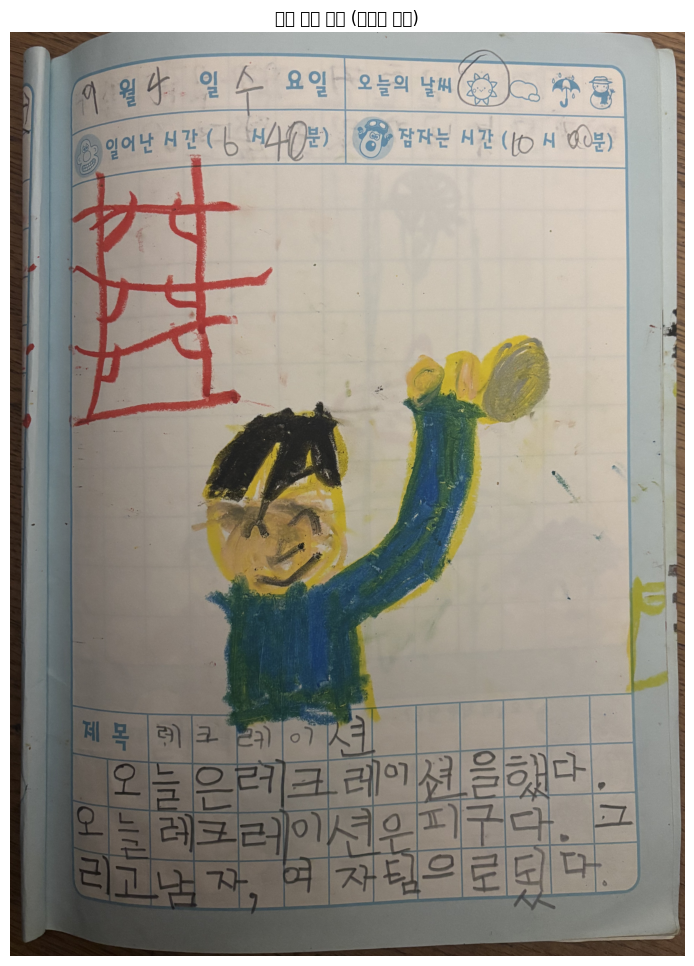

💾 탐지 박스 이미지 저장: img1_bbox.jpg


In [ ]:
# ========== 설정: 그림일기 이미지 경로 ==========
file_path = "img1.jpg"
max_long_side = 2048   # 그림일기 한 줄씩 읽기: 2048 권장. VRAM 부족하면 1536으로 낮추기
show_preprocess = False  # True면 전처리 결과 이미지 표시
show_detection = True   # True면 문서 영역 탐지 결과 이미지 표시
save_detection_images = True  # True면 탐지/OCR 결과 이미지 파일로 저장
# ===============================================

if not os.path.exists(file_path):
    print(f"❌ 파일을 찾을 수 없습니다: {file_path}")
else:
    try:
        # 1) 전처리 (문서 영역 탐지 + 보정)
        result = preprocess_diary_image(file_path, show_result=show_preprocess, return_detection_vis=True)
        if len(result) == 3:
            pil_image, preprocessed_bgr, detection_vis_bgr = result
        else:
            pil_image, preprocessed_bgr = result
            detection_vis_bgr = None
        print(f"✅ 전처리 완료: {file_path}")

        # 1-1) 문서 영역 탐지 결과 이미지 표시/저장
        if detection_vis_bgr is not None:
            if show_detection:
                plt.figure(figsize=(12, 12))
                plt.title("📐 문서 영역 탐지 결과 (초록=탐지된 4각형, 빨강=꼭짓점)")
                plt.imshow(cv2.cvtColor(detection_vis_bgr, cv2.COLOR_BGR2RGB))
                plt.axis("off")
                plt.show()
            if save_detection_images:
                out_path = file_path.rsplit(".", 1)[0] + "_detection.jpg"
                cv2.imwrite(out_path, detection_vis_bgr)
                print(f"💾 탐지 결과 저장: {out_path}")

        # 2) VARCO OCR
        raw_output, text_boxes, full_text, pil_image_sent = run_varco_ocr(pil_image, max_long_side=max_long_side)

        # 3) 결과 출력
        display_text = get_diary_text(raw_output, full_text)
        print("\n" + "=" * 50)
        print("📄 추출된 텍스트 (그림일기 한 줄씩)")
        print("=" * 50)
        print(display_text if display_text.strip() else raw_output)
        print("=" * 50)
        if text_boxes:
            print("\n📦 텍스트 박스 (문자/단어별 좌표)")
            for i, item in enumerate(text_boxes[:20]):  # 상위 20개만 출력
                print(f"  [{i+1}] {item['text']!r} -> bbox: {item['bbox']}")
            if len(text_boxes) > 20:
                print(f"  ... 외 {len(text_boxes) - 20}개")

        # 4) 글자 위치 탐지 결과: 모델이 본 이미지 위에 바운딩 박스 그리기
        vis = cv2.cvtColor(np.array(pil_image_sent), cv2.COLOR_RGB2BGR)
        h_vis, w_vis = vis.shape[:2]
        if text_boxes:
            for item in text_boxes:
                bbox = item.get("bbox")
                if bbox is None or len(bbox) < 4:
                    continue
                x1, y1, x2, y2 = bbox
                if max(x1, y1, x2, y2) <= 1.0:
                    x1, x2 = int(x1 * w_vis), int(x2 * w_vis)
                    y1, y2 = int(y1 * h_vis), int(y2 * h_vis)
                else:
                    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                cv2.rectangle(vis, (x1, y1), (x2, y2), (0, 255, 0), 3)
        print("\n📐 글자 위치 탐지 결과 (바운딩 박스) - 모델이 본 이미지 위에 탐지된 글자 영역을 그렸습니다.")
        plt.figure(figsize=(12, 12))
        plt.title("글자 위치 탐지 (바운딩 박스)")
        plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()
        if save_detection_images:
            bbox_path = file_path.rsplit(".", 1)[0] + "_bbox.jpg"
            cv2.imwrite(bbox_path, vis)
            print(f"💾 탐지 박스 이미지 저장: {bbox_path}")

        del pil_image, preprocessed_bgr, pil_image_sent, raw_output, text_boxes
        clean_memory()
    except Exception as e:
        print(f"❌ 오류: {e}")
        import traceback
        traceback.print_exc()
        clean_memory()